In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
df = pd.read_csv('../data/housing.csv')
df.shape

(506, 14)

In [3]:
df.dtypes

x1     float64
x2     float64
x3     float64
x4       int64
x5     float64
x6     float64
x7     float64
x8     float64
x9       int64
x10      int64
x11    float64
x12    float64
x13    float64
y      float64
dtype: object

In [4]:
df.isnull().any()

x1     False
x2     False
x3     False
x4     False
x5     False
x6     False
x7     False
x8     False
x9     False
x10    False
x11    False
x12    False
x13    False
y      False
dtype: bool

In [5]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,y
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [6]:
x = df.drop(['y'], axis=1).astype('float32')
t = df['y'].astype('float32')
x.shape, t.shape

((506, 13), (506,))

In [7]:
x = x.values
x.dtype, x.shape

(dtype('float32'), (506, 13))

In [8]:
t = t.values
t = t.reshape(len(t), 1)
t.dtype, t.shape

(dtype('float32'), (506, 1))

In [9]:
import chainer
import chainer.links as L
import chainer.functions as F
from chainer.training import extensions

In [10]:
dataset = list(zip(x, t))

In [11]:
n_train = int(len(dataset) * 0.7)
train, test = chainer.datasets.split_dataset_random(dataset, 
                                                    n_train,
                                                    seed=0)

In [12]:
len(train), len(test)

(354, 152)

In [13]:
train[0][0].shape, train[0][1]

((13,), array([22.6], dtype=float32))

In [14]:
# define model
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, 1)
            
    # forward
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [15]:
# Fix seed / hyperparameter
np.random.seed(0)
batchsize = 10
epoch = 100
device = -1

# define model
nn = NN()
model = L.Classifier(nn, lossfun=F.mean_squared_error)
model.compute_accuracy = False

# Setting Learning
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                                            repeat=False,
                                            shuffle=False)

updater = chainer.training.StandardUpdater(train_iter, 
                                           optimizer,
                                          device=device)

trainer = chainer.training.Trainer(updater,
                                   (epoch, 'epoch'),
                                   out='result/regg')
trainer.extend(extensions.Evaluator(test_iter, 
                                    model, device=device))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

trainer.run()

In [16]:
trainer.elapsed_time, trainer.observation

(6.166848504002701,
 {'main/loss': variable(240.4399), 'validation/main/loss': 70.49882316589355})

関数化して改善していく

In [17]:
# define model
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, 1)
            
    # forward
    def __call__(self, x):
        h = self.fc1(x)
        h = F.relu(h)
        h = self.fc2(h)
        return h

In [18]:
def model_train(nn, setting):
    # Fix seed / hyperparameter
    np.random.seed(0)
    batchsize = setting['batch_size']
    epoch = setting['epochs']
    if setting['device'] == 'CPU':
        device = -1
    elif setting['device'] == 'GPU':
        device = 0

    # Fix seed / hyperparameter
    np.random.seed(0)
    batchsize = 10
    epoch = 100
    device = -1

    # define model
    model = L.Classifier(nn, lossfun=F.mean_squared_error)
    model.compute_accuracy = False

    # Setting Learning
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    train_iter = chainer.iterators.SerialIterator(train, batchsize)
    test_iter = chainer.iterators.SerialIterator(test, batchsize,
                                                repeat=False,
                                                shuffle=False)

    updater = chainer.training.StandardUpdater(train_iter, 
                                               optimizer,
                                              device=device)

    trainer = chainer.training.Trainer(updater,
                                       (epoch, 'epoch'),
                                       out='./result/regg')
    trainer.extend(extensions.Evaluator(test_iter, 
                                        model, device=device))
    trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

    trainer.run()
    
    print('Learn time:', trainer.elapsed_time)
    print('Valid loss:', trainer.observation['validation/main/loss'])
    print('Valid RMSE:', np.sqrt(trainer.observation['validation/main/loss']))
    
    with open('./result/regg/log') as f:
        result = pd.DataFrame(json.load(f))

    result[['main/loss', 'validation/main/loss']].plot()
    
    return model

Learn time: 6.345996138999908
Valid loss: 58.43198323249817
Valid RMSE: 7.6440815820148185


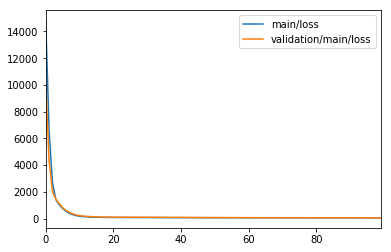

In [19]:
chainer_model = NN()
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 8.593097986999055
Valid loss: 25.171178862452507
Valid RMSE: 5.017088683933393


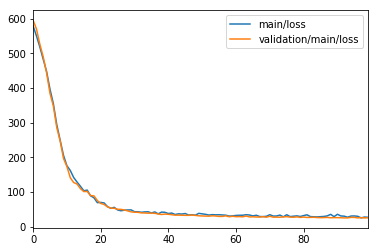

In [20]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(n_mid_units, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        return h

chainer_model = NN(10)
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 11.367734813000425
Valid loss: 22.580593317747116
Valid RMSE: 4.751904178089781


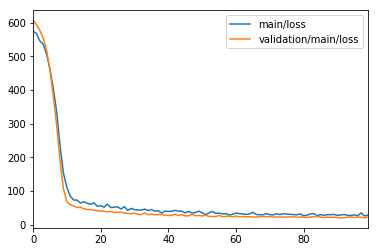

In [21]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        return h

chainer_model = NN()
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 10.806389168999885
Valid loss: 13.262530446052551
Valid RMSE: 3.64177572703929


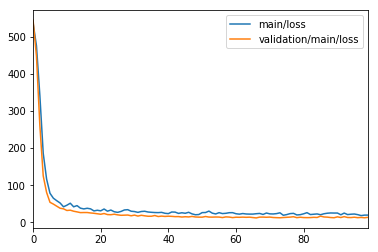

In [22]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        return h

chainer_model = NN(20)
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 13.613099065001734
Valid loss: 11.063908264040947
Valid RMSE: 3.326245370390006


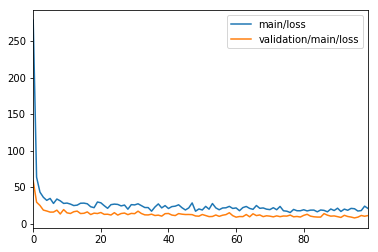

In [23]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        return h

chainer_model = NN(200)
setting = {
    'batch_size': 100,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 81.05999915000211
Valid loss: 7.628625839948654
Valid RMSE: 2.7619967125159026


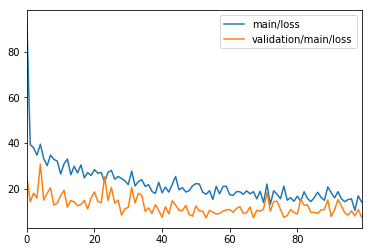

In [24]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        return h

chainer_model = NN(1000)
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 23.55397302700294
Valid loss: 14.927029117941856
Valid RMSE: 3.8635513608520666


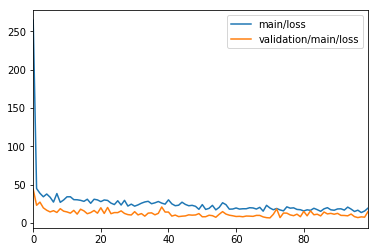

In [28]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, 100)
            self.fc3 = L.Linear(None, 50)
            self.fc4 = L.Linear(None, 10)
            self.fc5 = L.Linear(10, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        h = F.relu(h)
        h = self.fc4(h)
        h = F.relu(h)
        h = self.fc5(h)
        return h

chainer_model = NN(1000)
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

Learn time: 15.905169564997777
Valid loss: 86.09162247180939
Valid RMSE: 9.278557133078904


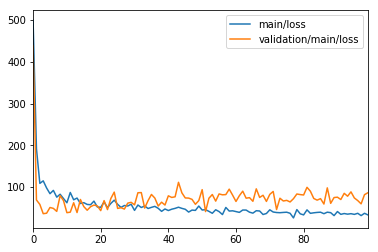

In [30]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, 100)
            self.fc3 = L.Linear(None, 50)
            self.fc4 = L.Linear(None, 10)
            self.fc5 = L.Linear(10, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.75)
        h = self.fc2(h)
        h = F.relu(h)
        h = F.dropout(h, ratio=0.5)
        h = self.fc3(h)
        h = F.relu(h)
        h = self.fc4(h)
        h = F.relu(h)
        h = self.fc5(h)
        return h

chainer_model = NN(100)
setting = {
    'batch_size': 50,
    'epochs': 10,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)

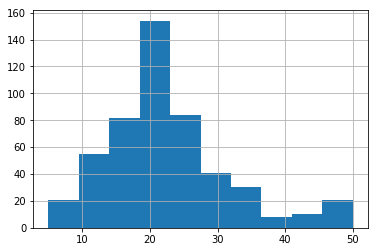

In [37]:
df['y'].hist()

In [43]:
# 元データのyがでかい部分をけす
df_dropped = df[df['y'] <= 48]
df_dropped.shape, df.shape

x = df.drop(['y'], axis=1).astype('float32')
t = df_drop['y'].astype('float32')

x = x.values
t = t.values
t = t.reshape(len(t), 1)
dataset = list(zip(x, t))

n_train = int(len(dataset) * 0.7)
train, test = chainer.datasets.split_dataset_random(dataset, 
                                                    n_train,
                                                    seed=0)

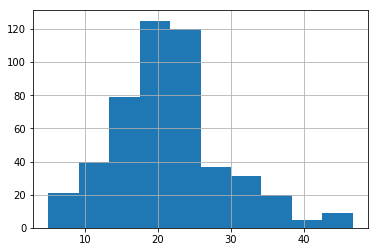

In [44]:
df_dropped['y'].hist()

Learn time: 80.03375353099909
Valid loss: 7.468472994863987
Valid RMSE: 2.7328507084844547


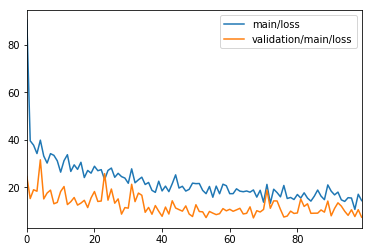

In [46]:
input_shape = train[0][0].shape[0]

class NN(chainer.Chain):
    def __init__(self, n_mid_units=5):
        super().__init__()
        with self.init_scope():
            self.fc1 = L.Linear(input_shape, n_mid_units)
            self.fc2 = L.Linear(None, n_mid_units)
            self.fc3 = L.Linear(n_mid_units, 1)
            self.bn = L.BatchNormalization(input_shape)
            
    # forward
    def __call__(self, x):
        h = self.bn(x)
        h = self.fc1(h)
        h = F.relu(h)
        h = self.fc2(h)
        h = F.relu(h)
        h = self.fc3(h)
        return h

chainer_model = NN(1000)
setting = {
    'batch_size': 50,
    'epochs': 50,
    'device': 'CPU'
}

model = model_train(chainer_model, setting)